# Single Experiment — EDMD

This notebook keeps the successful flow intact and adds:
- **RMSE per state + overall** for the plotted window.
- A **random contiguous test (validation) window** evaluation + plot + RMSE.
Nothing is written to disk or to the HDF5.


In [3]:
# ---- Config ----
from pathlib import Path

EXP_FILE = Path("../../datasets/go1/flat_terrain/experiment8.h5")  # <<< edit if needed

# EDMD hyperparameters
P_MAX   = 5            # max polynomial degree for EDMD
L2_REG  = 1e-6         # l2 regularization for EDMD
VAL_FR  = 0.2          # fraction of data for validation
H       = 20           # prediction horizon for open lop eval
SEED    = 42           # used for random test window
RANDOM_DEGREES = False # if your eval expects degrees for angles, set True

print("[config] exp file:", EXP_FILE.resolve())
print("[config] EDMD: p_max={}, l2_reg={}, val_frac={}, H={}, seed={}".format(P_MAX, L2_REG, VAL_FR, H, SEED))


[config] exp file: /home/sriramk/quad_koopman_mpc/datasets/go1/flat_terrain/experiment8.h5
[config] EDMD: p_max=5, l2_reg=1e-06, val_frac=0.2, H=20, seed=42


In [5]:
# ---- Imports ----
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

from h5_reader import H5Reader
from data_loader import QuadrupedEDMDDataset

# EDMD utilities (geometric basis + runner)
from basis import observables as geom_observables       
from edmd_runner import (
    edmd_with_inputs,
    train_val_split,
    rollout_open_loop_geom,   # <-- new rollout
    lift_1d, lift_row,        # <-- lift wrappers
    decode_state_from_geom_phi,
)

# Evaluator
from eval_nstep import eval_nstep_window

plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.figsize"] = (6.0, 4.0)

# Global RNG
rng = np.random.default_rng(SEED)


In [ ]:
# ---- Build X0, X1, U0 via your loader ----
assert EXP_FILE.exists(), f"Dataset file not found: {EXP_FILE}"

reader = H5Reader(file_path=str(EXP_FILE), lazy=True)
ds = QuadrupedEDMDDataset(
    dataset=reader,
    downsample=1,
    pos_zero_start=True,
    normalize=None,
).build()

X0, X1, U0 = ds.X0, ds.X1, ds.U0
labels = getattr(ds, "labels", None)

print("X0 shape:", X0.shape, "X1 shape:", X1.shape, "U0 shape:", U0.shape)
if labels is not None:
    print("labels[:6]:", labels[:min(6, len(labels))])


X0 shape: (2999800, 12) X1 shape: (2999800, 12) U0 shape: (2999800, 12)


In [7]:
# ---- Fit EDMD and prepare splits (with val_mask) ----
splits = train_val_split(X0, X1, U0, val_frac=VAL_FR)
tr, va = splits["train"], splits["val"]
print(f"[split] train N={tr['X0'].shape[0]}  |  val N={va['X0'].shape[0]}")

# Add the val_mask required by eval_nstep_window (last chunk is validation)
N_total = X0.shape[0]
N_val   = va["X0"].shape[0]
val_mask = np.zeros(N_total, dtype=bool)
val_mask[N_total - N_val : N_total] = True
splits["val_mask"] = val_mask

# Geometric basis lift (per-sample → 1-D φ)
lift_fn = lambda x: lift_1d(x, P_MAX)

# Fit EDMD (covariance form)
A, B = edmd_with_inputs(tr["X0"], tr["X1"], tr["U0"], lift_fn=lift_fn, l2_reg=L2_REG)

# Report lifted dimension and input size
nphi = lift_fn(tr["X0"][0]).shape[0]
nu   = tr["U0"].shape[1] if tr["U0"].ndim == 2 else 0
print(f"[model] n_phi={nphi}  |  nu={nu}  |  p_max={P_MAX}  |  l2_reg={L2_REG}")


[split] train N=2399840  |  val N=599960
[model] n_phi=69  |  nu=12  |  p_max=5  |  l2_reg=1e-06


Spectral radius ρ(A) = 1.017203
Max |eig|: 1.017203  (stable if < 1 for discrete-time)


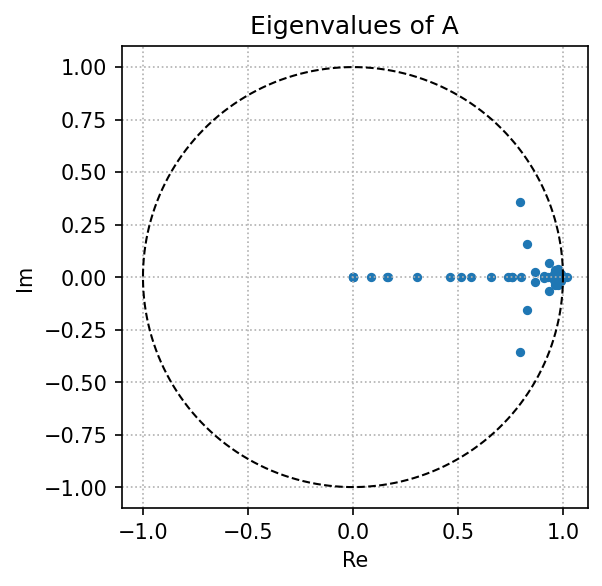

Controllability rank = 63 / 69  -> NOT full


In [9]:
# --- eigs & spectral radius ---
eigA = np.linalg.eigvals(A)
rhoA = np.max(np.abs(eigA))
print(f"Spectral radius ρ(A) = {rhoA:.6f}")
print(f"Max |eig|: {np.abs(eigA).max():.6f}  (stable if < 1 for discrete-time)")

# --- plot eigenvalues with unit circle ---
theta = np.linspace(0, 2*np.pi, 400)
plt.figure()
plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)  # unit circle
plt.scatter(eigA.real, eigA.imag, s=12)
plt.gca().set_aspect('equal', 'box')
plt.grid(True, linestyle=':')
plt.title("Eigenvalues of A")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

# --- controllability of (A,B) in lifted space ---
n = A.shape[0]
nu = B.shape[1]
blocks = []
AB = B.copy()
for i in range(n):
    blocks.append(AB)
    AB = A @ AB
Ctrb = np.hstack(blocks)  # (n, n*nu)

rank = np.linalg.matrix_rank(Ctrb)
print(f"Controllability rank = {rank} / {n}  -> {'FULL' if rank == n else 'NOT full'}")

## Random test window + RMSE
Picks a random contiguous H-step window inside the validation region; same plots and metrics.


In [10]:
# ---- RMSE helper (explicit; matches edmd_runner logic) ----
import numpy as np
import pandas as pd

def _wrap_to_pi(a: np.ndarray) -> np.ndarray:
    return (a + np.pi) % (2*np.pi) - np.pi

def compute_rmse(X_true: np.ndarray, X_pred: np.ndarray, wrap_euler: bool = True):
    """
    Compute per-state RMSE and overall RMSE.
    - Wraps Euler-angle residuals (indices 3..5) to (-π, π] when state dim == 12.
    - Overall RMSE = RMS of per-state RMSEs.
    """
    X_true = np.asarray(X_true, float)
    X_pred = np.asarray(X_pred, float)
    assert X_true.shape == X_pred.shape, f"shape mismatch: {X_true.shape} vs {X_pred.shape}"

    err = X_pred - X_true
    if wrap_euler and X_true.shape[1] == 12:
        err[:, 3:6] = _wrap_to_pi(err[:, 3:6])

    rmse_per_state = np.sqrt(np.mean(err**2, axis=0))
    overall_rmse   = float(np.sqrt(np.mean(rmse_per_state**2)))
    return rmse_per_state, overall_rmse

def rmse_table(rmse_per_state: np.ndarray, labels=None, k: int | None = None) -> pd.DataFrame:
    """
    Convenience: build a small table for display. If k is given, show first k states.
    """
    n = len(rmse_per_state)
    if labels is None or len(labels) != n:
        labels = [f"x{i}" for i in range(n)]
    df = pd.DataFrame({"state": labels, "rmse": rmse_per_state})
    return df.head(k) if k is not None else df


In [26]:
# ---- Eval on 10 random validation TRAJECTORIES (windows confined within a single episode) ----
import numpy as np, pandas as pd, h5py
from pathlib import Path

N_WINDOWS = 10  # how many random traj windows to evaluate

# --- helper: get episode transition slices (start,length) for the flattened X0/X1/U0 ---
def episode_transition_slices(h5_path: Path):
    """
    Returns a list of (start, length) for each episode's transitions in the flattened arrays.
    For an episode with T raw timestamps, there are (T-1) one-step transitions.
    """
    h5_path = Path(h5_path)
    with h5py.File(h5_path, "r") as f:
        E, T, _ = f["recordings"]["base_pos"].shape  # (episodes, timesteps, 3)
    lengths = np.full(E, max(T - 1, 0), dtype=int)
    # cumulative starts in the flattened transition arrays
    starts = np.cumsum(np.concatenate([[0], lengths[:-1]]))
    return [(int(starts[i]), int(lengths[i])) for i in range(E)]

# --- infer the HDF5 path from common notebook vars (adjust if you use a different name) ---
_h5_candidates = []
for nm in ("EXP_FILE", "data_path", "H5_PATH", "FILE_PATH"):
    if nm in globals():
        try:
            p = Path(str(globals()[nm]))
            if p.exists():
                _h5_candidates.append(p)
        except Exception:
            pass
if not _h5_candidates:
    raise RuntimeError("Could not infer HDF5 path. Please ensure EXP_FILE (or data_path) exists.")
H5_PATH = _h5_candidates[0]

# --- compute validation index range (contiguous tail) ---
idx_val = np.flatnonzero(splits["val_mask"])
assert idx_val.size >= H, "Validation region shorter than H; reduce H or increase val_frac."
val_start_idx = int(idx_val.min())
val_end_idx   = int(idx_val.max())  # inclusive

# --- build per-episode validation segments that can fit an H-step window ---
ep_slices = episode_transition_slices(H5_PATH)
eligible = []  # list of dicts with episode-local val segment
for e_idx, (s_ep, len_ep) in enumerate(ep_slices):
    if len_ep <= 0:
        continue
    # intersect episode [s_ep, s_ep+len_ep-1] with val range [val_start_idx, val_end_idx]
    seg_start = max(s_ep, val_start_idx)
    seg_end   = min(s_ep + len_ep, val_end_idx + 1)  # exclusive
    seg_len   = seg_end - seg_start
    if seg_len >= H:
        eligible.append(dict(
            episode_idx=e_idx,
            seg_start=int(seg_start),
            seg_len=int(seg_len),
            ep_start=int(s_ep),
            ep_len=int(len_ep),
        ))

assert len(eligible) > 0, "No validation episode has length ≥ H. Increase val_frac or reduce H."

# --- sample 10 random episodes from eligible, choose a random window inside each ---
if len(eligible) >= N_WINDOWS:
    chosen = rng.choice(len(eligible), size=N_WINDOWS, replace=False)
else:
    # sample with replacement if there are fewer than 10 eligible episodes
    chosen = rng.choice(len(eligible), size=N_WINDOWS, replace=True)

windows = []
for ci in chosen:
    seg = eligible[int(ci)]
    max_offset = seg["seg_len"] - H
    offset = int(rng.integers(0, max_offset + 1))
    start_idx = seg["seg_start"] + offset
    windows.append(dict(
        episode_idx=seg["episode_idx"],
        start_idx=int(start_idx),
        offset=int(offset),
        H_eff=int(H),
        ep_len=seg["ep_len"],
    ))

# --- run eval_nstep_window on each window (strict; radians) and collect metrics ---
per_window_rmse = []
overall_list    = []
used_rows       = []

for w in windows:
    res = eval_nstep_window(
        A, B, lambda x: lift_1d(x, P_MAX),
        ds, splits,
        X0, X1, U0,
        P_MAX, w["H_eff"],
        start_index=w["start_idx"],
        degrees=False,   # angles are SI radians
    )
    X_true_w = res["X_true_plot"]
    X_pred_w = res["X_pred_plot"]
    labels_w = res["labels"]

    rmse_s, overall = compute_rmse(X_true_w, X_pred_w)  # uses the helper we defined
    per_window_rmse.append(rmse_s)
    overall_list.append(overall)

    used_rows.append({
        "episode_idx": w["episode_idx"],
        "start_idx": w["start_idx"],
        "start_offset_in_episode": w["offset"],
        "H": w["H_eff"],
        "episode_len": w["ep_len"],
        "overall_rmse": float(overall),
    })

per_window_rmse = np.vstack(per_window_rmse)
overall_arr     = np.asarray(overall_list)

# --- aggregate mean ± std across the 10 random windows ---
mean_rmse_s = per_window_rmse.mean(axis=0)
std_rmse_s  = per_window_rmse.std(axis=0, ddof=0)
mean_overall = float(overall_arr.mean())
std_overall  = float(overall_arr.std(ddof=0))

# --- report ---
print(f"[eval/val] {len(windows)} random traj windows | overall RMSE = {mean_overall:.6f} ± {std_overall:.6f}")
df_used = pd.DataFrame(used_rows)
display(df_used)

labels_eval = labels_w[:len(mean_rmse_s)] if "labels_w" in locals() else [f"x{i}" for i in range(len(mean_rmse_s))]
df_perstate = pd.DataFrame({
    "state": labels_eval,
    "rmse_mean": mean_rmse_s,
    "rmse_std": std_rmse_s,
})
display(df_perstate.head(12))


[eval/val] 10 random traj windows | overall RMSE = 0.021098 ± 0.015387


,episode_idx,start_idx,start_offset_in_episode,H,episode_len,overall_rmse
0,99,2970842,1040,20,29998,0.006033
1,97,2916819,7013,20,29998,0.043256
2,92,2784448,24632,20,29998,0.018651
3,94,2821559,1747,20,29998,0.010142
4,81,2455490,25652,20,29998,0.008451
5,86,2588263,8435,20,29998,0.020992
6,89,2697332,27510,20,29998,0.003671
7,85,2558631,8801,20,29998,0.050000
8,87,2622846,13020,20,29998,0.034788
9,88,2659667,19843,20,29998,0.014995


,state,rmse_mean,rmse_std
0,pos.x [m],0.000065,0.000058
1,pos.y [m],0.000076,0.000044
2,pos.z [m],0.000624,0.000480
3,roll [rad],0.000891,0.000728
4,pitch [rad],0.001043,0.001160
5,yaw [rad],0.000170,0.000105
6,v.x [m/s],0.003924,0.002757
7,v.y [m/s],0.004060,0.002465
8,v.z [m/s],0.020878,0.017966
9,ω.x [rad/s],0.027659,0.022181


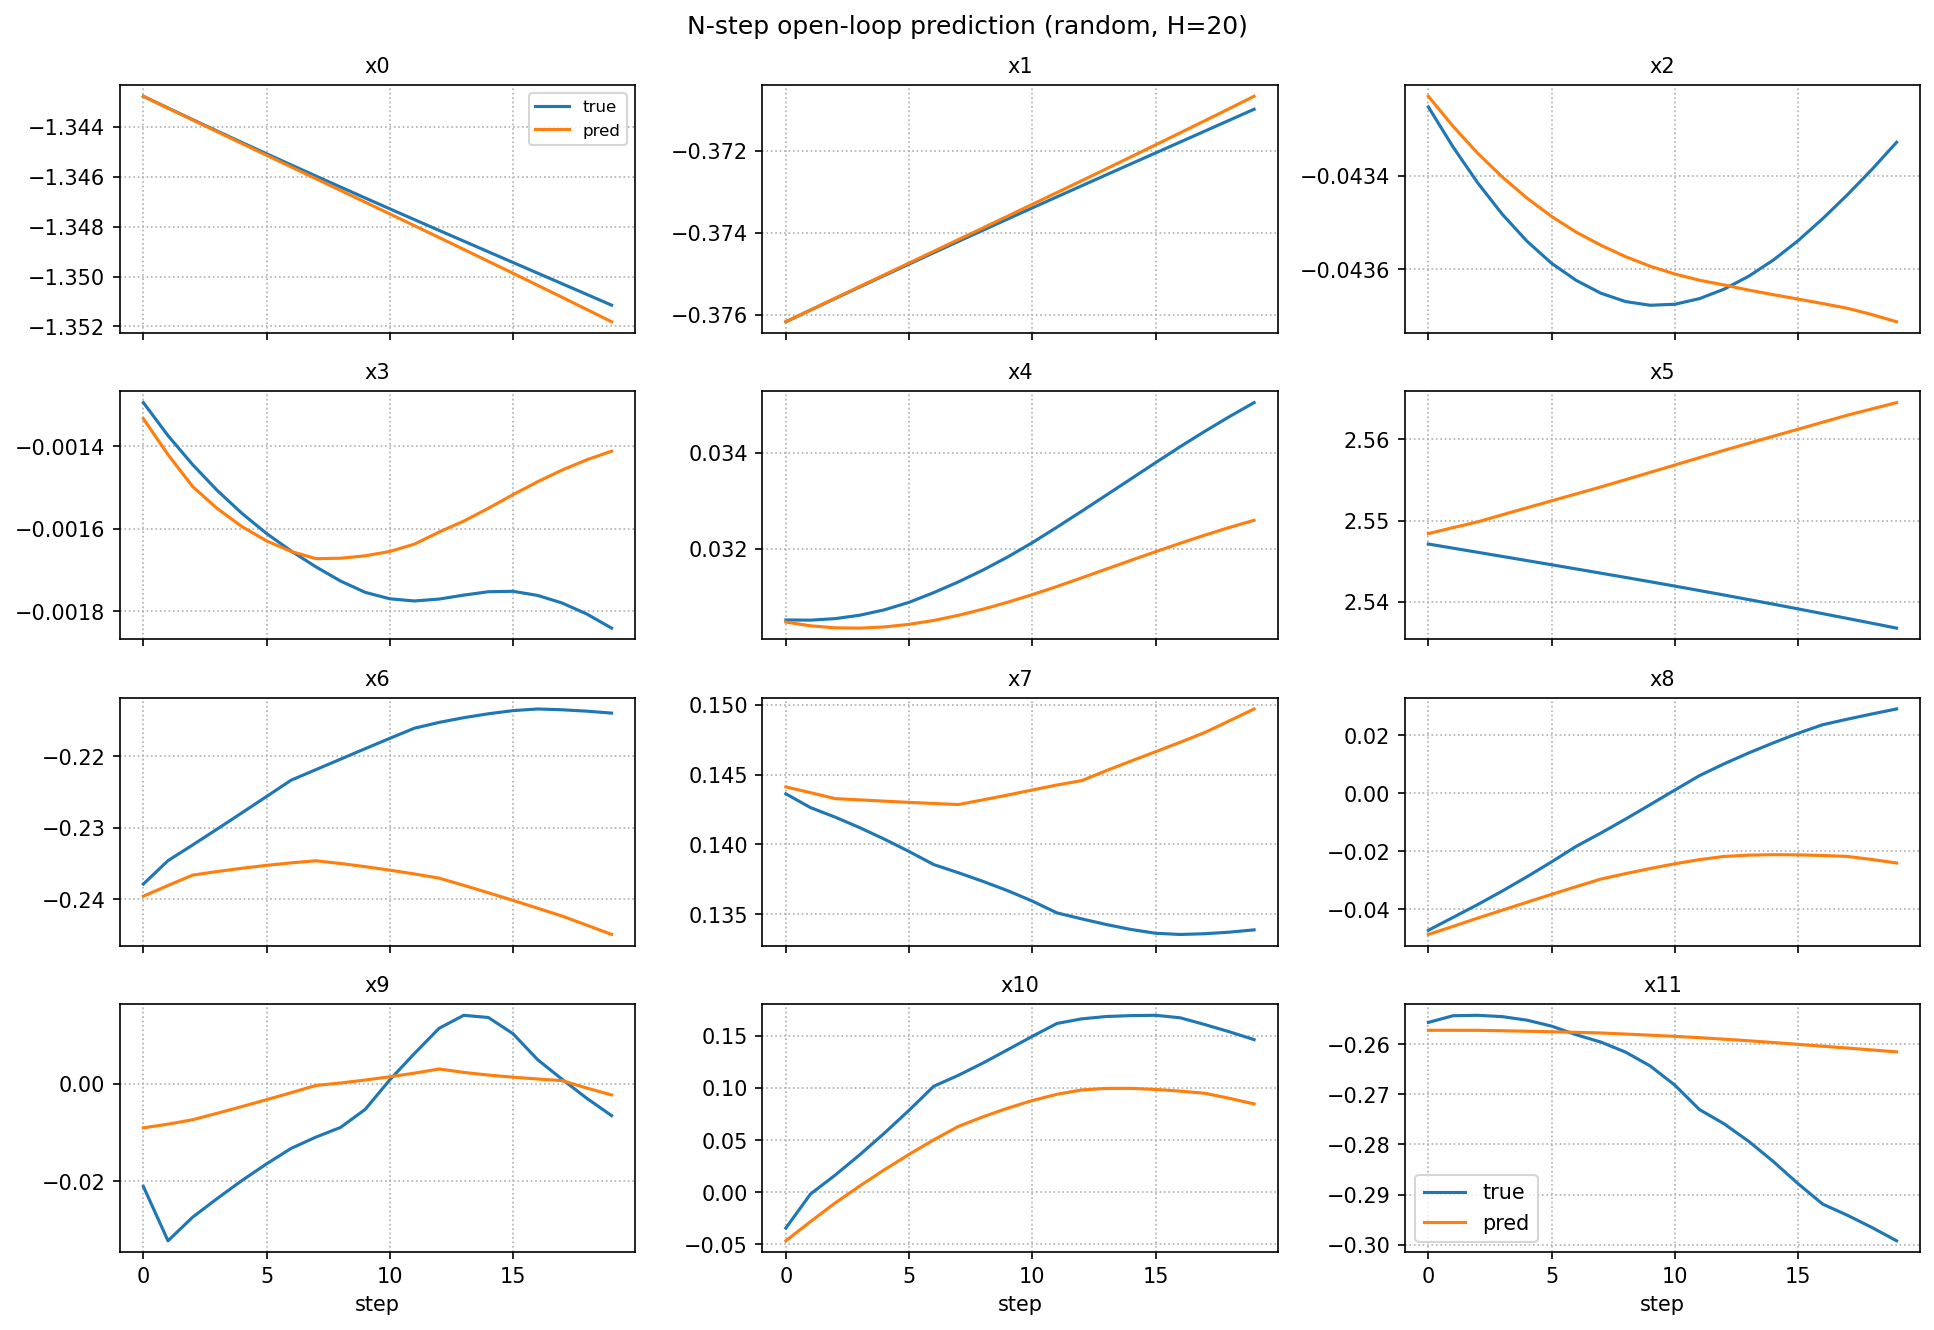

In [10]:
# ---- Plot 4x3 for random window (no saving) ----
fig, axes = plt.subplots(4, 3, figsize=(13, 9), sharex=True)
axes = axes.ravel()

nx = X_true_r.shape[1]
n_plot = min(12, nx)

for i in range(n_plot):
    ax = axes[i]
    ax.plot(t_r, X_true_r[:, i], label="true")
    ax.plot(t_r, X_pred_r[:, i], label="pred")
    ax.set_title(labels_rand[i] if i < len(labels_rand) else f"x{i}", fontsize=10)
    ax.grid(True, linestyle=':')

for j in range(n_plot, 12):
    axes[j].axis("off")

axes[-3].set_xlabel("step");  axes[-2].set_xlabel("step"); axes[-1].set_xlabel("step")
axes[0].legend(fontsize=8)
fig.suptitle(f"N-step open-loop prediction (random, H={len(t_r)})", y=0.98)
plt.tight_layout()
plt.legend()
plt.show()
